# Testing our implementations

In [3]:
# Importing numpy and all functions in implementations.py
import numpy as np
from implementations import *
import helpers as h

First we will need some testing data, so we're reusing the data from lab 2 and 3, and then making some training data of our own.

In [4]:
def load_data(sub_sample=True, add_outlier=False):
    """Load data and convert it to the metric system."""
    path_dataset = "./Data/height_weight_genders.csv"
    data = np.genfromtxt(path_dataset, delimiter=",", skip_header=1, usecols=[1, 2])
    height = data[:, 0]
    weight = data[:, 1]
    gender = np.genfromtxt(
        path_dataset,
        delimiter=",",
        skip_header=1,
        usecols=[0],
        converters={0: lambda x: 0 if b"Male" in x else 1},
    )
    # Convert to metric system
    height *= 0.025
    weight *= 0.454

    # sub-sample
    if sub_sample:
        height = height[::50]
        weight = weight[::50]

    if add_outlier:
        # outlier experiment
        height = np.concatenate([height, [1.1, 1.2]])
        weight = np.concatenate([weight, [51.5 / 0.454, 55.3 / 0.454]])

    return height, weight, gender

def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x)
    x = x - mean_x
    std_x = np.std(x)
    x = x / std_x
    return x, mean_x, std_x

def build_model_data(height, weight):
    """Form (y,tX) to get regression data in matrix form."""
    y = weight
    x = height
    num_samples = len(y)
    tx = np.c_[np.ones(num_samples), x]
    return y, tx

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [5]:
##### Make some training data #####
dataPoints = 100
#xarray = np.random.uniform(low=0, high=2*np.pi, size=(dataPoints,))
xarray = np.linspace(0,2*np.pi,dataPoints)
dummyFeature = np.ones(dataPoints)
yarray = np.sin(xarray) + np.random.normal(0,1,dataPoints) *0.1

In [6]:
testX = np.c_[dummyFeature,xarray,xarray**2]
testY = yarray
gamma = 0.0005  # The step size, these implementations are sensitive to it - It might be a good idea to implement a backtracking algorithm to find step sizes for each step that follow the weak or strong wolfe conditions
initial_w = np.zeros(testX.shape[1])

np.random.seed(30)

w_ls, loss_ls = least_squares(testY,testX)
w_gd, loss_gd = mean_squared_error_gd(testY,testX,initial_w,100,gamma)
w_gd_m, loss_gd_m = mse_gd_momentum(testY,testX,initial_w,100,gamma)
w_sgd, loss_sgd = mean_squared_error_sgd(testY,testX,initial_w,100,gamma)
w_sgd_m, loss_sgd_m, = mse_sgd_momentum(testY,testX,initial_w,100,gamma)
w_ridge, loss_ridge = ridge_regression(testY,testX,0)
w_reg_reg, loss_reg_reg = reg_logistic_regression(testY, testX, 0.0005 ,initial_w, 10, gamma)

print(f'''Normal equations: parameters: {w_ls}, loss: {loss_ls}
Gradient Descent: parameters: {w_gd}, loss: {loss_gd}
Gradient Descent with Momentum: parameters: {w_gd_m}, loss: {loss_gd_m}
Stochastic Gradient Descent: parameters: {w_sgd}, loss: {loss_sgd}
Stochastic Gradient Descent with Momentum: parameters: {w_sgd_m}, loss: {loss_sgd_m}
Ridge Regression: parameters: {w_ridge}, loss: {loss_ridge},
Regularized Regression: parameters: {w_reg_reg}, loss: {loss_reg_reg}''')

Normal equations: parameters: [ 0.98318909 -0.32326069  0.00341748], loss: 0.21234678144149158
Gradient Descent: parameters: [ 0.01243671  0.00789313 -0.02138599], loss: 0.3878372706484013
Gradient Descent with Momentum: parameters: [ 0.01231295  0.00778865 -0.02136003], loss: 0.3879508553933324
Stochastic Gradient Descent: parameters: [ 0.01412648  0.01127618 -0.00974232], loss: 0.43528490850036405
Stochastic Gradient Descent with Momentum: parameters: [ 0.00926719  0.0021288  -0.03460901], loss: 0.457141306060943
Ridge Regression: parameters: [ 0.98318909 -0.32326069  0.00341748], loss: 0.21234678144149158,
Regularized Regression: parameters: [-0.00202621 -0.01081875 -0.05441446], loss: 0.0842438753909735


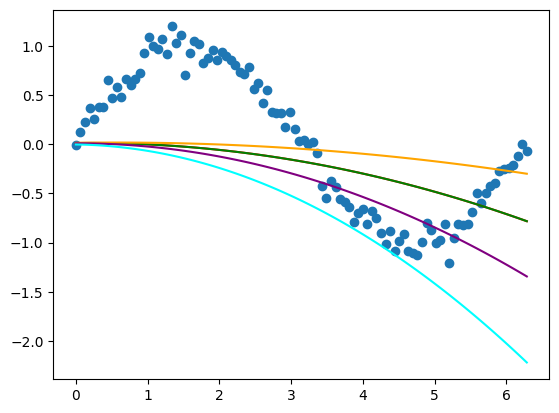

In [7]:
import matplotlib.pyplot as plt

plt.plot(testX[:,1],testX @ w_gd, color='red')
plt.plot(testX[:,1],testX @ w_gd_m, color='green')
plt.plot(testX[:,1],testX @ w_sgd, color='orange')
plt.plot(testX[:,1],testX @ w_sgd_m, color='purple')
plt.plot(testX[:,1],testX @ w_reg_reg, color='cyan')
plt.scatter(testX[:,1],testY)
plt.show()

From the loss, and illustrated in the plot, it is obvoious that the stochastic gradient descent may a problem with often missing the minimum by a wide margin. It therefore seems smart not to rely on it too much. Using it to find better initial guesses for another algorithm may seem like a better idea. The SGD with momentum seems to generally outperform it quite a lot though, for only a slight increase in computational complexity, so it may be a good idea to use SGD with momentum instead. Still, it is no perfect, and better results may be obtained by GD or GD with momentum. GD with momentum seems less sensitive (but still affected) by the step size.